# ECG DATASET

Demo for Beggel's ADSL algorithm implementation in pytorch 

In [1]:
import pandas as pd

import os 
os.chdir('/home/ludovicobartoli/Documents/Shapelets')

import numpy as np
import random
import torch
from torch import tensor

from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance

from src.preprocessing_anomaly import preprocessing_anomaly
from src.SVDD.SVDD import SVDD
from src.util import Scaler, euclidean_distance_shifted, length_normalized_distance, max_corr, get_weights_via_kmeans, mean_shift
from src.learning.learningextractor import LearningShapelets 
from src.learning.similarityloss import DiscrepancySimilarity, CorrelationSimilairty
from src.searching.bruteforce_multivariate import Bruteforce_extractor_mv, Candidateset
from src.searching.RLS import RLS_extractor, RLS_candidateset

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


/opt/anaconda3/envs/ludo_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set up the dataset

### Read the data

In [2]:
dataframe = pd.read_csv('demo/data/ecg.csv', header=None)
raw_data = dataframe.values
X_train = dataframe.to_numpy()
print('Data shape', X_train.shape)
y_train = np.array(X_train[:,140], dtype='int')
X_train = np.delete(X_train, obj=140, axis=1)
N, Q = X_train.shape
X_train = X_train.reshape((N,Q,1))

len(y_train[y_train==0])
obs_perclass = [len(y_train[y_train==i]) for i in set(y_train)]
print(f'Number of total samples in each class: {obs_perclass}')
n_class = len(obs_perclass)

Data shape (4998, 141)
Number of total samples in each class: [2079, 2919]


### Preprocessing

Plot one sample per class:

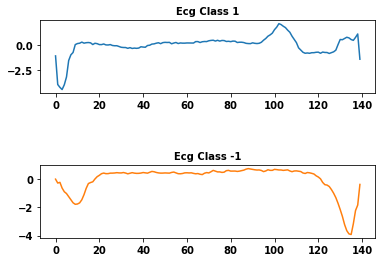

In [3]:
fig, ax = plt.subplots(n_class,)

ts = X_train[y_train==1][1,:,0]
ax[0].set_title(f'Ecg Class {1}', fontsize=10, fontweight="bold")
ax[0].plot(ts, color='tab:blue')
ts = X_train[y_train==0][1,:,0]
ax[1].set_title(f'Ecg Class {-1}', fontsize=10, fontweight="bold")
ax[1].plot(ts, color='tab:orange')
plt.subplots_adjust(hspace=1)
plt.show()

#### Create anomaly detection dataset:

In [4]:
np.random.seed(0)
alpha=0.01
normal_class = 1
normal_prop = 0.7
valid_prop = 0.3
X_train_anomaly, y_train_anomaly, X_test_anomaly, y_test_anomaly, X_valid_anomaly, y_valid_anomaly = preprocessing_anomaly(X_train, y_train, alpha=alpha, normal_class=normal_class, normal_prop=normal_prop, valid_prop=valid_prop)


Get statistics of the anomaly detection dataset:

In [5]:
N, Q,_ = X_train_anomaly.shape
print('Ecg dataset')
print(f'number train ts is {N}, each of length {Q}')
print(f'They belong to two possible classes: {set(y_train_anomaly)}')
print('number test ts', len(X_test_anomaly))
print('number of normal train series:', len(y_train_anomaly[y_train_anomaly==1]))
print('number of anomalous train series:', len(y_train_anomaly[y_train_anomaly==-1]))
print('number of normal valid series:', len(y_valid_anomaly[y_valid_anomaly==1]))
print('number of anomalous valid series:', len(y_valid_anomaly[y_valid_anomaly==-1]))
print('number of normal test series:', len(y_test_anomaly[y_test_anomaly==1]))
print('number of anomalous test series:', len(y_test_anomaly[y_test_anomaly==-1]))

Ecg dataset
number train ts is 2063, each of length 140
They belong to two possible classes: {1, -1}
number test ts 2055
number of normal train series: 2043
number of anomalous train series: 20
number of normal valid series: 276
number of anomalous valid series: 604
number of normal test series: 600
number of anomalous test series: 1455


#### Normalize:

In [6]:
# normalize the time series
# as in the tutorial https://tslearn.readthedocs.io/en/stable/auto_examples/classification/plot_shapelets.html#sphx-glr-auto-examples-classification-plot-shapelets-py
scaler = TimeSeriesScalerMinMax()
X_train_anomaly = scaler.fit_transform(X_train_anomaly)
X_test_anomaly = scaler.fit_transform(X_test_anomaly)
X_valid_anomaly = scaler.fit_transform(X_valid_anomaly)

In [7]:
# normalizer = Normalizer(scaler=StandardScaler())
# X_train_anomaly = normalizer.fit_normalize(X_train_anomaly)
# X_test_anomaly = normalizer.normalize(X_test_anomaly)

#### Plot train set

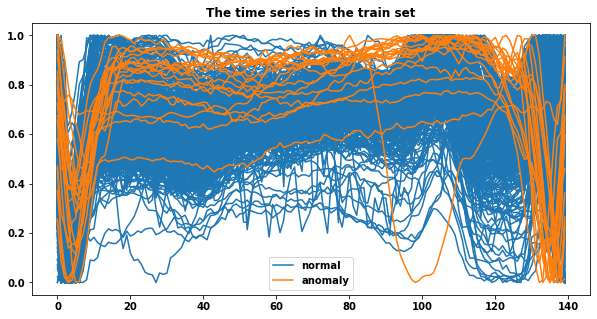

In [8]:
plt.figure(figsize=(10, 5))
for i in range(len(X_train_anomaly[y_train_anomaly==1][:,:,0])):
    ts = X_train_anomaly[y_train_anomaly==1][i,:,0]
    plt.plot(range(len(ts)), ts, c='tab:blue', label='normal' if i==0 else None)
for i in range(len(X_train_anomaly[y_train_anomaly==-1][:,:,0])):
    ts = X_train_anomaly[y_train_anomaly==-1][i,:,0]
    plt.plot(range(len(ts)), ts, c='tab:orange', label='anomaly' if i==0 else None)
plt.legend()
plt.title('The time series in the train set', fontweight="bold")
plt.show()


## Train the model:

Implementation of Beggel's "Anomaly Detection algorithm with Shapelet-based Feature Learning" (ADSL).
K Shapelets of length L are parametrized; given the shapelet transform of a multivariate time series $t^i$ with C channels:
\begin{equation}
x^i = (x^i_1, \dots, x^i_K), \enspace x^i_k = min_{l=1,\dots, J} \left\lVert s^k  - t^i_{l, l+L}\right\rVert^2
\end{equation}

Define $l(x^i) = \sum_{k=1}^K (x^i_k)^2$ the norm of the transform vector in $R^K$

Given a batch of N time series, the loss to minimize is:
\begin{equation}
L_S(t^1,\dots,t^N) = \frac{1}{N} (\sum_{i=1}^N max(0, l(x^i) - R^2) C +  \sum_{i=1}^N l(x^i))
\end{equation}
where R is the radius of the last update of the SVDD boundary, C is the hyperparameter of the SVDD.

#### K-Means Inizialization 

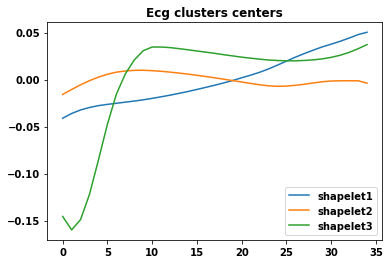

The shape of cluster centers is torch.Size([3, 1, 35])


In [9]:
K_star =  0.02
L_star = 0.25
L = round(L_star*Q)
K = round(K_star*Q)
n_segments = N*(Q-K+1)
# clusters_centers = get_weights_via_kmeans(X_train_anomaly, len_shapelets=L, num_shapelets=K, n_segments=n_segments)
clusters_centers = np.load(f'demo/data/ecg_clusters_K={K}_L={L}.npy')

# np.save(f'demo/data/ecg_clusters_K={K}_L={L}', clusters_centers)

# plot the mean-shifted clusters' centers
S_init = clusters_centers - np.mean(clusters_centers, axis=1, keepdims=True)

plt.figure()
for i in range(len(S_init)):
    shap = S_init[i,:,]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('Ecg clusters centers', fontweight="bold")
plt.show()

dtype = torch.double
clusters_centers = torch.tensor(clusters_centers.transpose(0,2,1), dtype=dtype)
clusters_centers = clusters_centers - torch.mean(clusters_centers, dim=2, keepdim=True)

print(f'The shape of cluster centers is {clusters_centers.shape}') 

### TRAINING

In [17]:
# overestimate proportin of anomalies
C = 1 / (N * 0.1) 
l1 = 0.5 # shapelet similarity parameter

print('Cuda available?', torch.cuda.is_available())
loss_sim = DiscrepancySimilarity()
extractor = LearningShapelets(len_shapelets=L, num_shapelets=K, in_channels=1, C=C, verbose=1, to_cuda=True, l1=l1, loss_sim=loss_sim)
extractor.set_shapelet_weights(clusters_centers)

lr = 1e-1
optimizer = torch.optim.SGD(extractor.model.parameters(), lr=lr, momentum=0.9)
extractor.set_optimizer(optimizer)

n_epoch_steps = 50
n_epochs = 1
# total epochs = n_epoch_steps * n_epochs
batch_size = N

# Input shape must be a pytorch TENSOR with shape (n_samples, in_channels, len_ts)
X_train_tensor = tensor(X_train_anomaly, dtype=dtype).contiguous().transpose(1,2).cuda()
X_test_tensor = tensor(X_test_anomaly, dtype=dtype).contiguous().transpose(1,2).cuda()
X_valid_tensor = tensor(X_valid_anomaly, dtype=dtype).contiguous().transpose(1,2).cuda()

extractor.compute_radius(X_train_tensor, tol=1e-6)

extractor.model(X_train_tensor).shape

losses_dist_train = []
losses_sim = []
for epoch in range(n_epoch_steps):
    print(f'Epoch: {epoch}')
    extractor.compute_radius(X_train_tensor, tol=1e-6)
    print('radius', extractor.loss_func.get_radius())
    current_loss_dist, current_loss_sim = extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)
    # current_loss_dist = extractor.fit(X_train_tensor, epochs=n_epochs, batch_size=batch_size)
    print('Loss sim:', current_loss_sim)
    losses_dist_train += current_loss_dist
    losses_sim += current_loss_sim

Cuda available? True
Epoch: 0
radius 0.29866675688668076


Loss dist: 0.41872450369617265: 100%|██████████| 1/1 [00:00<00:00, 52.09it/s]

Loss sim: [0.48870679289339064]
Epoch: 1


radius 0.2446275468673696


Loss dist: 0.3083539466454813: 100%|██████████| 1/1 [00:00<00:00, 43.16it/s]

Loss sim: [0.48866299912815103]
Epoch: 2


radius 0.24290326267676207


Loss dist: 0.2855949852849064: 100%|██████████| 1/1 [00:00<00:00, 43.02it/s]

Loss sim: [0.48768004742613985]
Epoch: 3


radius 0.2544840315701567


Loss dist: 0.3159337525355341: 100%|██████████| 1/1 [00:00<00:00, 48.92it/s]

Loss sim: [0.48486281437303086]
Epoch: 4


radius 0.28833199513363317


Loss dist: 0.3180356245302954: 100%|██████████| 1/1 [00:00<00:00, 44.08it/s]

Loss sim: [0.48057957248449884]
Epoch: 5


radius 0.2836170469722572


Loss dist: 0.31661761366164687: 100%|██████████| 1/1 [00:00<00:00, 48.29it/s]

Loss sim: [0.4796203231835222]
Epoch: 6


radius 0.24126529390063525


Loss dist: 0.2817546825258923: 100%|██████████| 1/1 [00:00<00:00, 49.18it/s]

Loss sim: [0.4873610544828844]
Epoch: 7


radius 0.22934585547555408


Loss dist: 0.2845130105342783: 100%|██████████| 1/1 [00:00<00:00, 55.92it/s]

Loss sim: [0.4940533224517504]
Epoch: 8


radius 0.23427906610951227


Loss dist: 0.30038637615215796: 100%|██████████| 1/1 [00:00<00:00, 48.32it/s]

Loss sim: [0.4950403505392808]
Epoch: 9


radius 0.23249222537204486


Loss dist: 0.3086846049936881: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s]

Loss sim: [0.49336407530506143]
Epoch: 10


radius 0.22137955313000626


Loss dist: 0.2867188460589142: 100%|██████████| 1/1 [00:00<00:00, 71.62it/s]

Loss sim: [0.49411900447975476]
Epoch: 11


radius 0.21269648505523264


Loss dist: 0.26830196372665127: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

Loss sim: [0.4948611314635403]
Epoch: 12


radius 0.22237523953995122


Loss dist: 0.2695696308875122: 100%|██████████| 1/1 [00:00<00:00, 45.21it/s]

Loss sim: [0.49396457562715157]
Epoch: 13


radius 0.22907129524617498


Loss dist: 0.2675778529055447: 100%|██████████| 1/1 [00:00<00:00, 53.19it/s]

Loss sim: [0.4945004013838438]
Epoch: 14


radius 0.2169543944231766


Loss dist: 0.25398191687195776: 100%|██████████| 1/1 [00:00<00:00, 48.85it/s]

Loss sim: [0.49562938058257466]
Epoch: 15


radius 0.206895503655081


Loss dist: 0.2520910030149136: 100%|██████████| 1/1 [00:00<00:00, 48.49it/s]

Loss sim: [0.4968247414015996]
Epoch: 16


radius 0.20045305728129623


Loss dist: 0.2444411630443849: 100%|██████████| 1/1 [00:00<00:00, 47.61it/s]

Loss sim: [0.49888349612340577]
Epoch: 17


radius 0.2043864989342866


Loss dist: 0.24700013628635026: 100%|██████████| 1/1 [00:00<00:00, 43.60it/s]

Loss sim: [0.49789526563549175]
Epoch: 18


radius 0.20937635993043408


Loss dist: 0.2460183120823794: 100%|██████████| 1/1 [00:00<00:00, 48.81it/s]

Loss sim: [0.49783208490330394]
Epoch: 19


radius 0.20460563312704275


Loss dist: 0.23645325808325474: 100%|██████████| 1/1 [00:00<00:00, 46.13it/s]

Loss sim: [0.49843293352690643]
Epoch: 20


radius 0.20480890605497504


Loss dist: 0.24017751251724562: 100%|██████████| 1/1 [00:00<00:00, 47.17it/s]

Loss sim: [0.4974717171257069]
Epoch: 21


radius 0.20480446396770222


Loss dist: 0.24251356163936896: 100%|██████████| 1/1 [00:00<00:00, 47.60it/s]

Loss sim: [0.4975037720599453]
Epoch: 22


radius 0.20182890251817423


Loss dist: 0.2298905797521503: 100%|██████████| 1/1 [00:00<00:00, 48.49it/s]

Loss sim: [0.49807845830654696]
Epoch: 23


radius 0.20494737374919533


Loss dist: 0.23596716124051087: 100%|██████████| 1/1 [00:00<00:00, 47.81it/s]

Loss sim: [0.49799457857197627]
Epoch: 24


radius 0.20133971192791006


Loss dist: 0.22959940634336928: 100%|██████████| 1/1 [00:00<00:00, 45.28it/s]

Loss sim: [0.49872927241781884]
Epoch: 25


radius 0.19850490876503182


Loss dist: 0.22514492344267972: 100%|██████████| 1/1 [00:00<00:00, 44.89it/s]

Loss sim: [0.49906135457971196]
Epoch: 26


radius 0.19856122600745066


Loss dist: 0.22834361828778682: 100%|██████████| 1/1 [00:00<00:00, 48.23it/s]

Loss sim: [0.49934646147438466]
Epoch: 27


radius 0.1977077312796609


Loss dist: 0.22170824034127656: 100%|██████████| 1/1 [00:00<00:00, 47.39it/s]

Loss sim: [0.4993231736391949]
Epoch: 28


radius 0.20536091386253874


Loss dist: 0.2247242308522639: 100%|██████████| 1/1 [00:00<00:00, 51.09it/s]

Loss sim: [0.49897076159084613]
Epoch: 29


radius 0.2012902936865591


Loss dist: 0.22024884940425488: 100%|██████████| 1/1 [00:00<00:00, 43.71it/s]

Loss sim: [0.498960193981533]
Epoch: 30


radius 0.19755489259815506


Loss dist: 0.22462229948898982: 100%|██████████| 1/1 [00:00<00:00, 50.53it/s]

Loss sim: [0.49884504072103586]
Epoch: 31


radius 0.1965990323468801


Loss dist: 0.2227859997404416: 100%|██████████| 1/1 [00:00<00:00, 48.50it/s]

Loss sim: [0.4989647767782615]
Epoch: 32


radius 0.1976570133149881


Loss dist: 0.22045440639985608: 100%|██████████| 1/1 [00:00<00:00, 46.99it/s]

Loss sim: [0.49894858465609965]
Epoch: 33


radius 0.19969094802296372


Loss dist: 0.22051415243686268: 100%|██████████| 1/1 [00:00<00:00, 43.87it/s]

Loss sim: [0.4991746028904772]
Epoch: 34


radius 0.19744437788143207


Loss dist: 0.2172595228127511: 100%|██████████| 1/1 [00:00<00:00, 49.98it/s]

Loss sim: [0.49955793213891864]
Epoch: 35


radius 0.19759738441703123


Loss dist: 0.21915878727541083: 100%|██████████| 1/1 [00:00<00:00, 47.90it/s]

Loss sim: [0.49964246793906836]
Epoch: 36


radius 0.196991239258162


Loss dist: 0.21609813307220865: 100%|██████████| 1/1 [00:00<00:00, 48.75it/s]

Loss sim: [0.4998148794689099]
Epoch: 37


radius 0.196306209213682


Loss dist: 0.21816045137712278: 100%|██████████| 1/1 [00:00<00:00, 47.94it/s]

Loss sim: [0.4997419254423989]
Epoch: 38


radius 0.19918282537951087


Loss dist: 0.21499767977510828: 100%|██████████| 1/1 [00:00<00:00, 53.57it/s]

Loss sim: [0.499831510601547]
Epoch: 39


radius 0.19663224104572574


Loss dist: 0.21661164143233236: 100%|██████████| 1/1 [00:00<00:00, 44.75it/s]

Loss sim: [0.4997822716203052]
Epoch: 40


radius 0.19482012131712212


Loss dist: 0.21644806629072205: 100%|██████████| 1/1 [00:00<00:00, 48.84it/s]

Loss sim: [0.4997890537446844]
Epoch: 41


radius 0.1950353914000847


Loss dist: 0.2161686239998109: 100%|██████████| 1/1 [00:00<00:00, 42.93it/s]

Loss sim: [0.4997768871179333]
Epoch: 42


radius 0.19817864479819314


Loss dist: 0.21465436848033725: 100%|██████████| 1/1 [00:00<00:00, 45.14it/s]

Loss sim: [0.4997999443253957]
Epoch: 43


radius 0.19752443138176085


Loss dist: 0.21418735229154967: 100%|██████████| 1/1 [00:00<00:00, 48.95it/s]

Loss sim: [0.4998496654305962]
Epoch: 44


radius 0.19435669773099773


Loss dist: 0.2155424994704161: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s]

Loss sim: [0.4998663449045101]
Epoch: 45


radius 0.19460684861575792


Loss dist: 0.21474317723820688: 100%|██████████| 1/1 [00:00<00:00, 47.85it/s]

Loss sim: [0.4999042504262165]
Epoch: 46


radius 0.19750855489570945


Loss dist: 0.2140677192235778: 100%|██████████| 1/1 [00:00<00:00, 53.50it/s]

Loss sim: [0.4998637237982167]
Epoch: 47


radius 0.19846777610170518


Loss dist: 0.2128678200294514: 100%|██████████| 1/1 [00:00<00:00, 47.88it/s]

Loss sim: [0.49987954859791645]
Epoch: 48


radius 0.19646347886406143


Loss dist: 0.2141772567699699: 100%|██████████| 1/1 [00:00<00:00, 47.29it/s]

Loss sim: [0.49983119869405357]
Epoch: 49


radius 0.19346847836556588


Loss dist: 0.21459967058933915: 100%|██████████| 1/1 [00:00<00:00, 48.79it/s]

Loss sim: [0.49987166771032915]


Loss Decay:

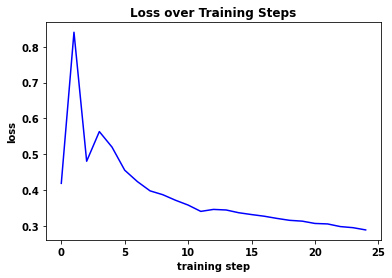

In [11]:
plt.plot(losses_dist_train, color='blue')
plt.title("Loss over Training Steps", fontweight="bold")
plt.xlabel("training step")
plt.ylabel("loss")
plt.show()

Shapelets:

Type and shape of the shapelets in output <class 'numpy.ndarray'> (3, 35, 1)


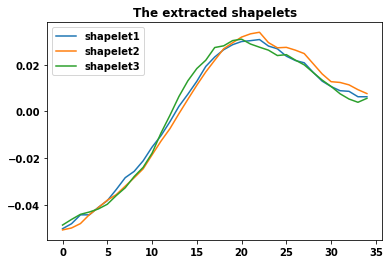

In [18]:
# plot the shapelets
S = extractor.get_shapelets()
# use moveaxis because the shapelets returned have shape (num_shapelets, in_channels, shapelets_size)
S = np.moveaxis(S, 1, 2)
print('Type and shape of the shapelets in output', type(S),  S.shape)

plt.figure()
for i in range(len(S)):
    shap = S[i,:,]
    plt.plot(shap, label=f'shapelet{i+1}')
plt.legend()
plt.title('The extracted shapelets', fontweight="bold")
plt.show()


Transform train and test set:

In [19]:
# tranform method takes in input a tensor of shape (n_samples, in_channels, len_ts) 
# and outputs a numpy array of shape (n_samples, n_shapelets)
X_train_transform = extractor.transform(X_train_tensor)
X_test_transform = extractor.transform(X_test_tensor)
X_valid_transform = extractor.transform(X_valid_tensor)

# check if type and shape are correct:
print('Type and shape of transformed train data', type(X_train_transform),  X_train_transform.shape)
print('Type and shape of transformed test data', type(X_test_transform),  X_test_transform.shape)

Type and shape of transformed train data <class 'numpy.ndarray'> (2063, 3)
Type and shape of transformed test data <class 'numpy.ndarray'> (2055, 3)


## Anomaly detection using SVDD

Choose how many extracted shapelets to take (2 for visualization purposes):

207 support vectors out of 2063 points
Solution found with center in 0.0 and radius 0.1959704527679523
Test balanced accuracy: 0.5221563573883161
Test F1 score: 0.22692533803644915
Test AUC: 0.7349381443298969
valid balanced accuracy: 0.5061306267396103
valid F1 score: 0.23236514522821577
Valid AUC: 0.7133961992513677


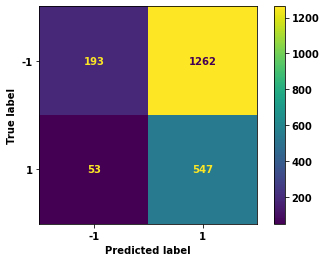

In [20]:
svdd = SVDD(C=C, zero_center=True, tol=1e-6, verbose=True, show_progress=False)

# fit the model
svdd.fit(X_train_transform)

# BALANCED ACCURACY
y_test_predict = svdd.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("Test balanced accuracy:", test_ba)
# F1 score
f1_test = f1_score(y_test_anomaly, y_test_predict, pos_label=-1)
print("Test F1 score:", f1_test)

# Confusion matrix for test 
cm = confusion_matrix(y_test_anomaly, y_test_predict)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[-1,1]).plot()
plt.show()

# AUC
y_test_scores = -svdd.decision_function(X_test_transform)
fpr, tpr, _ = roc_curve(y_test_anomaly, y_test_scores, pos_label=-1)
auc_test = auc(fpr, tpr)
print("Test AUC:", auc_test)

y_valid_predict = svdd.predict(X_valid_transform)
valid_ba = balanced_accuracy_score(y_valid_anomaly, y_valid_predict)
print("valid balanced accuracy:", valid_ba)
# F1 score
f1_valid = f1_score(y_valid_anomaly, y_valid_predict, pos_label=-1)
print("valid F1 score:", f1_valid)

y_valid_scores = -svdd.decision_function(X_valid_transform)
fpr, tpr, _ = roc_curve(y_valid_anomaly, y_valid_scores, pos_label=-1)
auc_valid = auc(fpr, tpr)
print("Valid AUC:", auc_valid)

In [36]:
# nu is the proportion of anomalies w.r.t. the total
nu = np.around(len(y_train_anomaly[y_train_anomaly==-1])/len(y_train_anomaly), 3)
print(nu)

# set C with real percentage of anomalies
C1 = 1 / (N * nu)
print(C1)

# set C according to Beggel's paper (smaller)
C2 = 1 / (N * alpha)
print(C2)

0.048
0.24801587301587302
0.23809523809523808


In [37]:
svdd = SVDD(C=C2, zero_center=True)

# fit the model
svdd.fit(X_train_transform)

5 support vectors out of 84 points
Solution found with center in 0.0 and radius 0.5540285110473633


EVALUATE the prediction:

In [38]:
## TRAIN
# BALANCED ACCURACY
y_train_predict = svdd.predict(X_train_transform)
train_ba = balanced_accuracy_score(y_train_anomaly, y_train_predict)
print("SVDD train balanced accuracy:", train_ba)

# AUC
y_train_scores = svdd.decision_function(X_train_transform)
auc_train = roc_auc_score(y_train_anomaly, y_train_scores)
print("SVDD train AUC:", auc_train)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("SVDD train F1 score:", f1_train)

SVDD train balanced accuracy: 0.60625
SVDD train AUC: 0.946875
SVDD train F1 score: 0.9625000000000001


In [39]:
## TEST
# BALANCED ACCURACY
y_test_predict = svdd.predict(X_test_transform)
test_ba = balanced_accuracy_score(y_test_anomaly, y_test_predict)
print("SVDD test balanced accuracy:", test_ba)

# AUC
y_test_scores = svdd.decision_function(X_test_transform)
auc_test = roc_auc_score(y_test_anomaly, y_test_scores)
print("SVDD test AUC:", auc_test)

# F1 score
f1_train = f1_score(y_train_anomaly, y_train_predict)
print("SVDD train F1 score:", f1_train)

SVDD test balanced accuracy: 0.6302083333333334
SVDD test AUC: 0.9973958333333334
SVDD train F1 score: 0.9625000000000001


### PLOTS (first two coordinates in shapelet transformed space):

NOTE: if were taken more than 2 shapelets the SVDD boundaries are plotted but they do not indicate the correct boundary in more than two dimension of the true points (the points are collapsed in the plane as if their other coordinates were equal to zero)

TRAIN DATA and SVDD boundary

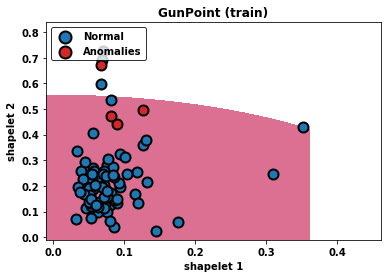

In [40]:
x_max = max(X_train_transform[:,0])+0.01
y_max = max(X_train_transform[:,1])+0.01
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = svdd.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_train = y_train_anomaly == 1
nIndex_train = y_train_anomaly == -1


plt.figure()
plt.title("ECG (train)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_train_transform[pIndex_train, 0], X_train_transform[pIndex_train, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_train_transform[nIndex_train, 0], X_train_transform[nIndex_train, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                    markerscale=1.2, fancybox=True)
plt.xlim((-0.01, x_max + 0.1))
plt.ylim((-0.01, y_max + 0.1))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()

TEST DATA and SVDD boundary

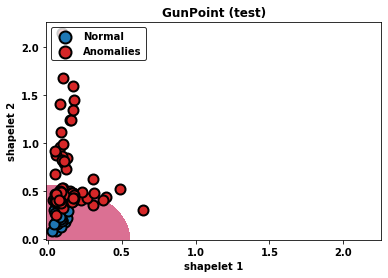

In [41]:
x_max = max(X_test_transform[:,0])+0.01
y_max = max(X_test_transform[:,1])+0.01
xx, yy = np.meshgrid(np.linspace(-0.1, x_max, 500), np.linspace(-0.1, y_max, 500))
Z = svdd.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pIndex_test = y_test_anomaly == 1
nIndex_test = y_test_anomaly == -1
auc_test = np.around(auc_test, 3)
plt.figure()
plt.title("ECG (test)", fontweight="bold")

plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")
plt.scatter(X_test_transform[pIndex_test, 0], X_test_transform[pIndex_test, 1], facecolor='C0', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Normal")

plt.scatter(X_test_transform[nIndex_test, 0], X_test_transform[nIndex_test, 1], facecolor='C3', marker='o', s=100, linewidths=2,
                     edgecolor='black', zorder=2, label="Anomalies")

plt.legend(ncol=1, loc='upper left', edgecolor='black',
                     markerscale=1.2, fancybox=True)

plt.xlim((-0.01, y_max + 0.1))
plt.ylim((-0.01, y_max + 0.1))
plt.ylabel("shapelet 2")
plt.xlabel("shapelet 1")
plt.show()